In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=15_000,
    k=k,
    min_length=8,
    max_length=16,
    balanced=0.5,
)

File data/dyck-1_15000-samples_16-len_p05.jsonl already exists.


In [8]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-1_15000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 15000/15000 [00:00<00:00, 129026.66it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Manual Transformer + BERTViz


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
    causal_mask
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [16]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [17]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-5)

In [19]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.1445 | Train Accuracy: 82.53%
Train Loss: 0.0179 | Train Accuracy: 91.25%
Train Loss: 0.0081 | Train Accuracy: 94.17%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.1397 | Validation Accuracy: 100.00%
Validation Loss: 0.2809 | Validation Accuracy: 100.00%
Train Loss: 51.8860 | Train Acc: 95.33%
Val Loss: 0.3161 | Val Acc: 100.00%
Epoch 2/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0031 | Train Accuracy: 100.00%
Train Loss: 0.0019 | Train Accuracy: 100.00%
Train Loss: 0.0013 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0280 | Validation Accuracy: 100.00%
Validation Loss: 0.0561 | Validation Accuracy: 100.00%
Train Loss: 0.9061 | Train Acc: 100.00%
Val Loss: 0.0630 | Val Acc: 100.00%
Epoch 3/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0006 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0097 | Validation Accuracy: 100.00%
Validation Loss: 0.0194 | Validation Accuracy: 100.00%
Train Loss: 0.2635 | Train Acc: 100.00%
Val Loss: 0.0218 | Val Acc: 100.00%
Epoch 4/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0046 | Validation Accuracy: 100.00%
Validation Loss: 0.0092 | Validation Accuracy: 100.00%
Train Loss: 0.1134 | Train Acc: 100.00%
Val Loss: 0.0104 | Val Acc: 100.00%
Epoch 5/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0026 | Validation Accuracy: 100.00%
Validation Loss: 0.0053 | Validation Accuracy: 100.00%
Train Loss: 0.0622 | Train Acc: 100.00%
Val Loss: 0.0059 | Val Acc: 100.00%
Epoch 6/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0016 | Validation Accuracy: 100.00%
Validation Loss: 0.0031 | Validation Accuracy: 100.00%
Train Loss: 0.0372 | Train Acc: 100.00%
Val Loss: 0.0035 | Val Acc: 100.00%
Epoch 7/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Validation Loss: 0.0021 | Validation Accuracy: 100.00%
Train Loss: 0.0242 | Train Acc: 100.00%
Val Loss: 0.0024 | Val Acc: 100.00%
Epoch 8/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Validation Loss: 0.0015 | Validation Accuracy: 100.00%
Train Loss: 0.0172 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 9/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0129 | Train Acc: 100.00%
Val Loss: 0.0014 | Val Acc: 100.00%
Epoch 10/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Train Loss: 0.0102 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/300 [00:00<?, ?it/s]

Test Loss: 0.0005 | Test Accuracy: 100.00%
Test Loss: 0.0010 | Test Accuracy: 100.00%
Test Loss: 0.0014 | Test Accuracy: 100.00%
Test Loss: 0.0014 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▆▃▃▆▆▆▅▅▅█▆▆▃▆▅▅▅▃▆▆▅▆▅▅▆▃▅█▆▅▁▆▃▃▆▅▅▅▅▅
train/acc,▁▅▆▇████████████████████████████████████
train/loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▇▇█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,0.0
train/acc,100.0
train/loss,2e-05
val/acc,100.0


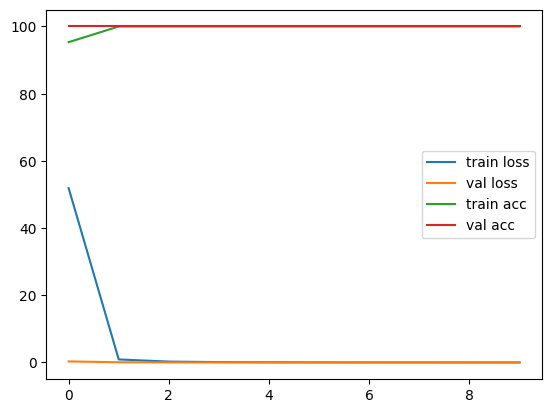

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [22]:
model_causal = TransformerClassifier(model_config).to(device)

In [23]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-6)

In [24]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7603 | Train Accuracy: 49.78%
Train Loss: 0.6896 | Train Accuracy: 50.45%
Train Loss: 0.7467 | Train Accuracy: 49.62%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3035 | Validation Accuracy: 50.75%
Validation Loss: 138.6030 | Validation Accuracy: 50.81%
Train Loss: 271.4029 | Train Acc: 49.46%
Val Loss: 155.9151 | Val Acc: 51.00%
Epoch 2/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.6797 | Train Accuracy: 50.31%
Train Loss: 0.7148 | Train Accuracy: 49.42%
Train Loss: 0.7305 | Train Accuracy: 49.79%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3649 | Validation Accuracy: 49.00%
Validation Loss: 138.7386 | Validation Accuracy: 48.88%
Train Loss: 270.4040 | Train Acc: 50.12%
Val Loss: 156.0711 | Val Acc: 49.00%
Epoch 3/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7566 | Train Accuracy: 52.28%
Train Loss: 0.7739 | Train Accuracy: 51.39%
Train Loss: 0.7120 | Train Accuracy: 50.72%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3740 | Validation Accuracy: 50.38%
Validation Loss: 138.9832 | Validation Accuracy: 49.00%
Train Loss: 269.0342 | Train Acc: 50.49%
Val Loss: 156.3561 | Val Acc: 49.00%
Epoch 4/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.8022 | Train Accuracy: 49.72%
Train Loss: 0.6837 | Train Accuracy: 49.66%
Train Loss: 0.7278 | Train Accuracy: 49.20%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3120 | Validation Accuracy: 50.38%
Validation Loss: 138.6079 | Validation Accuracy: 51.06%
Train Loss: 269.6857 | Train Acc: 49.22%
Val Loss: 155.9355 | Val Acc: 51.00%
Epoch 5/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7347 | Train Accuracy: 48.78%
Train Loss: 0.7872 | Train Accuracy: 49.33%
Train Loss: 0.6967 | Train Accuracy: 49.66%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.4176 | Validation Accuracy: 47.50%
Validation Loss: 138.7389 | Validation Accuracy: 48.88%
Train Loss: 268.9308 | Train Acc: 49.67%
Val Loss: 156.0714 | Val Acc: 49.00%
Epoch 6/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7023 | Train Accuracy: 50.56%
Train Loss: 0.7328 | Train Accuracy: 50.59%
Train Loss: 0.7789 | Train Accuracy: 50.52%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3191 | Validation Accuracy: 49.25%
Validation Loss: 138.6376 | Validation Accuracy: 49.31%
Train Loss: 267.1557 | Train Acc: 50.78%
Val Loss: 155.9711 | Val Acc: 49.00%
Epoch 7/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.6673 | Train Accuracy: 49.03%
Train Loss: 0.6855 | Train Accuracy: 49.50%
Train Loss: 0.7338 | Train Accuracy: 49.55%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3191 | Validation Accuracy: 49.25%
Validation Loss: 138.6396 | Validation Accuracy: 49.12%
Train Loss: 267.1335 | Train Acc: 50.20%
Val Loss: 155.9710 | Val Acc: 49.00%
Epoch 8/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7004 | Train Accuracy: 48.97%
Train Loss: 0.6610 | Train Accuracy: 49.53%
Train Loss: 0.6594 | Train Accuracy: 49.85%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3720 | Validation Accuracy: 49.38%
Validation Loss: 138.6084 | Validation Accuracy: 50.81%
Train Loss: 268.2738 | Train Acc: 49.83%
Val Loss: 155.9145 | Val Acc: 51.00%
Epoch 9/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7460 | Train Accuracy: 50.59%
Train Loss: 0.7119 | Train Accuracy: 50.25%
Train Loss: 0.7479 | Train Accuracy: 50.52%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.3302 | Validation Accuracy: 47.25%
Validation Loss: 138.6412 | Validation Accuracy: 49.00%
Train Loss: 266.6698 | Train Acc: 50.43%
Val Loss: 155.9713 | Val Acc: 49.00%
Epoch 10/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.7698 | Train Accuracy: 50.06%
Train Loss: 0.6569 | Train Accuracy: 49.14%
Train Loss: 0.7324 | Train Accuracy: 49.57%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 69.4424 | Validation Accuracy: 49.25%
Validation Loss: 138.6397 | Validation Accuracy: 50.88%
Train Loss: 267.7551 | Train Acc: 49.34%
Val Loss: 155.9484 | Val Acc: 51.00%


In [25]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

  0%|          | 0/300 [00:00<?, ?it/s]

Test Loss: 69.3481 | Test Accuracy: 50.50%
Test Loss: 138.9226 | Test Accuracy: 49.00%
Test Loss: 207.8558 | Test Accuracy: 51.33%
Test Loss: 207.8558 | Test Acc: 51.33%


test/acc,▇▁▁▄▅▆▃▄▅▅▆██▇▇▆▇▇▇▇█▇▆▆▆▆▆▆▇▇▇▇▇▇▇█████
test/loss,▅▅▅▃▅▅▆▅█▅▁▅▅▃▅▅▃▆▅▅▅▆▆▅▅▅▅▅▅▅▅▅▃▃▅▆▅█▁▃
train/acc,▄▃▄▃▁▄▃▃█▆▅▄▃▃▃▃▄▂▃▃▄▄▄▅▅▃▃▃▂▃▃▃▃▄▄▄▄▃▃▃
train/loss,▂▃▅▄▄▄▂▃▂▃▄▄▆▂▅▄█▂▃▆▁▃▅▃▆▄▃▄▅▆▄▃▁▂▄▂▂▄▄▄
val/acc,▇▆▇▇▅▆▅▅▅▅▆▅▆▇▆▆▂▄▅▅▇▆▅▅▂▆▆▅▁▆▇▇▅▅▅▅█▆▇▇
val/loss,▃▄▅▅▅▇▄▅▇▁▇▁▄▅▅▄▅▄▅▅▅▄▅▄▅▅▄▅▄▄▂▅▄▅▅▅▁█▅▆
test/acc,51.33333
test/loss,0.675
train/acc,49.34167
train/loss,0.78077
val/acc,51.0


# Attention plots:


In [63]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [27]:
from dataset.dataset import DyckLanguageTokenizer
from dyck_k_generator.checker import is_dyck_word

In [28]:
batch = [
    (
        ")))))))(((((((",
        "((((((()))))))",
        ")()()()()()()(",
        "()()()()()()()"
    ),
    torch.tensor(
        [
            is_dyck_word(")))))))(((((((", 1),
            is_dyck_word("((((((()))))))", 1),
            is_dyck_word(")()()()()()()(", 1),
            is_dyck_word("()()()()()()()", 1),
        ],
        dtype=torch.float32,
        device=device,
    ),
    torch.tensor(
        [
            DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("((((((()))))))").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize(")()()()()()()(").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("()()()()()()()").tolist()[0],
        ],
        device=device,
    ),
]
batch

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[(')))))))(((((((', '((((((()))))))', ')()()()()()()(', '()()()()()()()'),
 tensor([0., 1., 0., 1.], device='mps:0'),
 tensor([[0., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 2.],
         [0., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 2.],
         [0., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 2.],
         [0., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 2.]],
        device='mps:0')]

In [29]:
batch = next(iter(test_dataloader))

In [30]:
batch

[('((())((()()())))', '((((()))))', ')((((()(()((', ')((((()(()(('),
 tensor([1., 1., 0., 0.], device='mps:0'),
 tensor([[0., 3., 3., 3., 4., 4., 3., 3., 3., 4., 3., 4., 3., 4., 4., 4., 4., 2.],
         [0., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 4., 3., 3., 3., 3., 3., 4., 3., 3., 4., 3., 3., 2., 1., 1., 1., 1.],
         [0., 4., 3., 3., 3., 3., 3., 4., 3., 3., 4., 3., 3., 2., 1., 1., 1., 1.]],
        device='mps:0')]

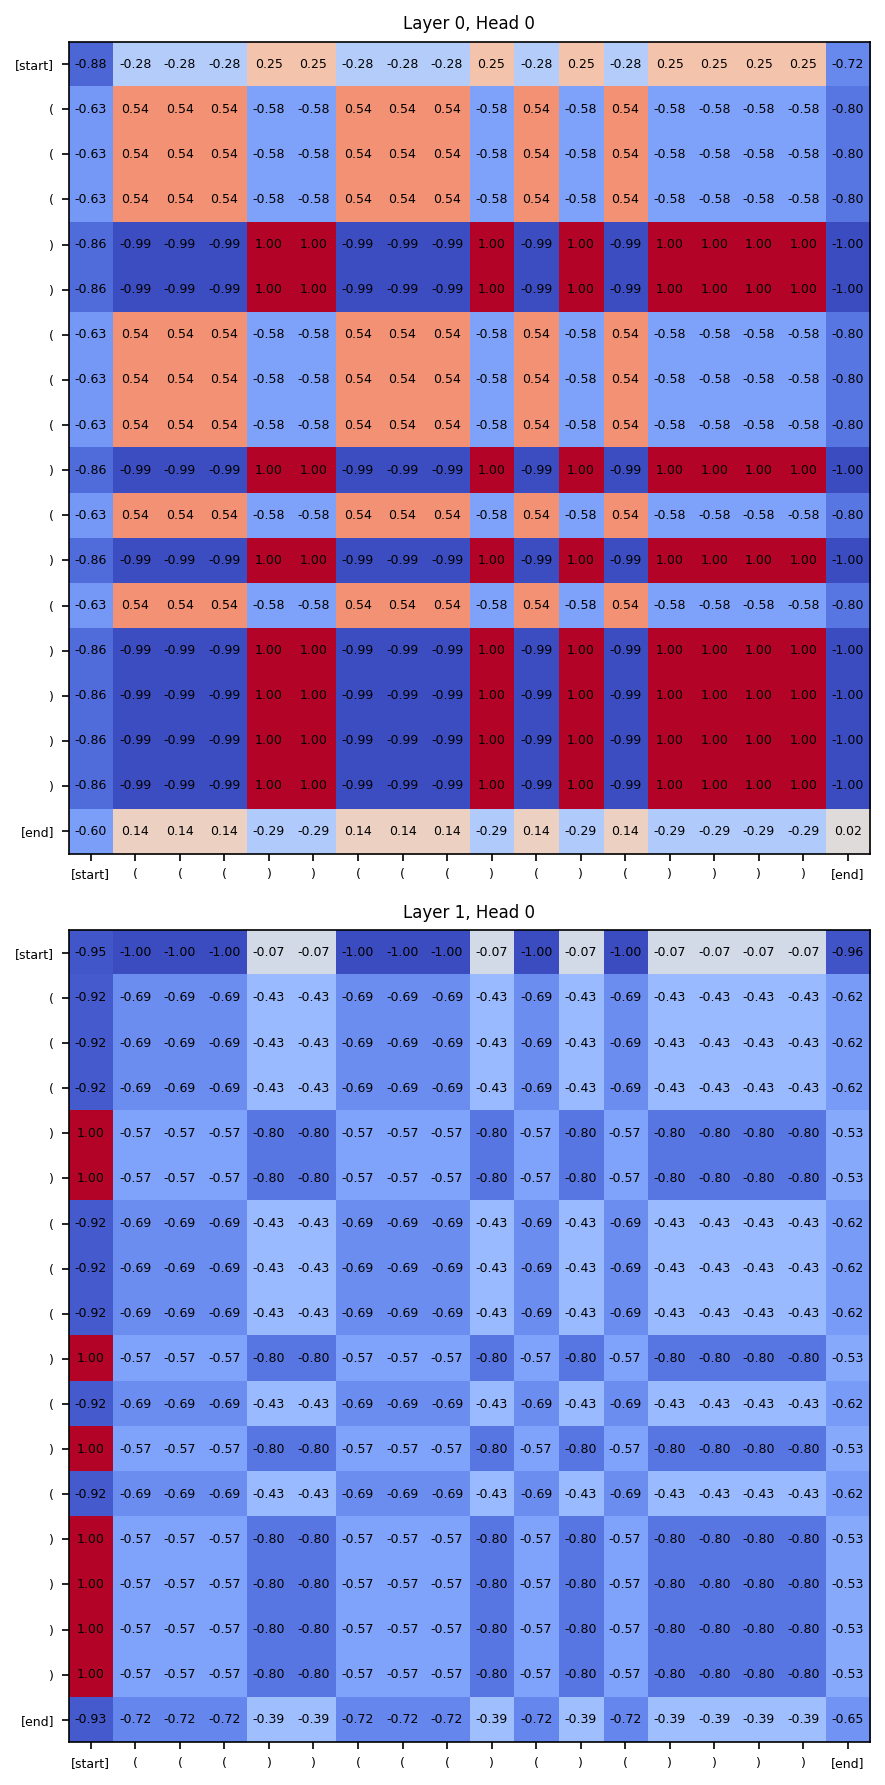

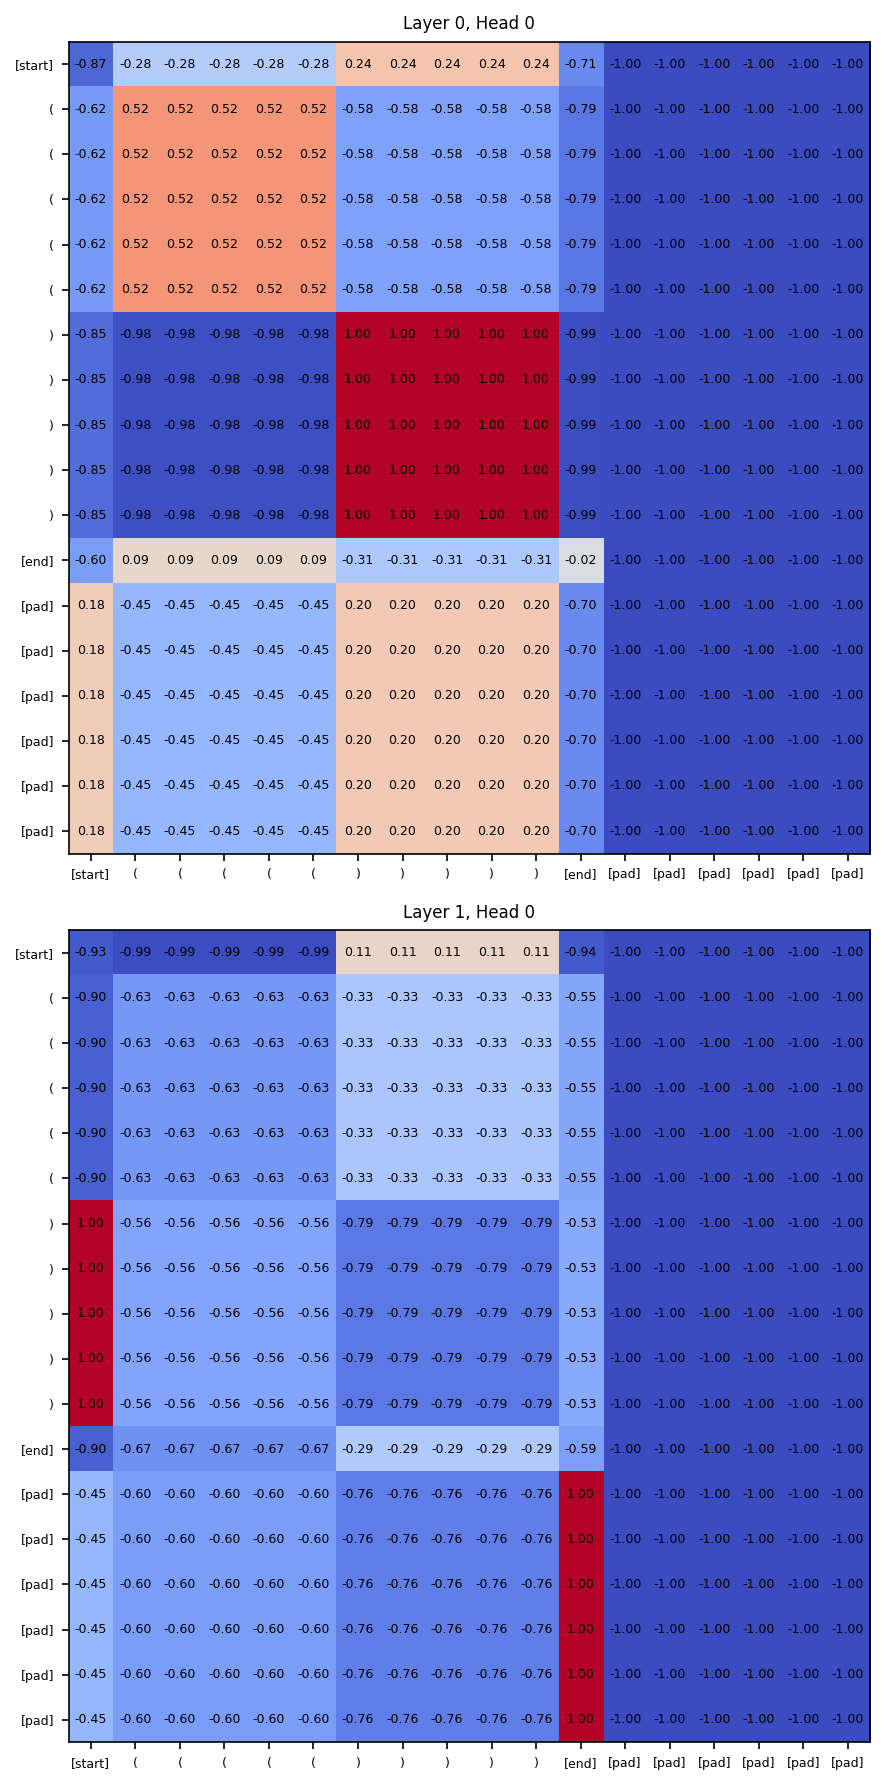

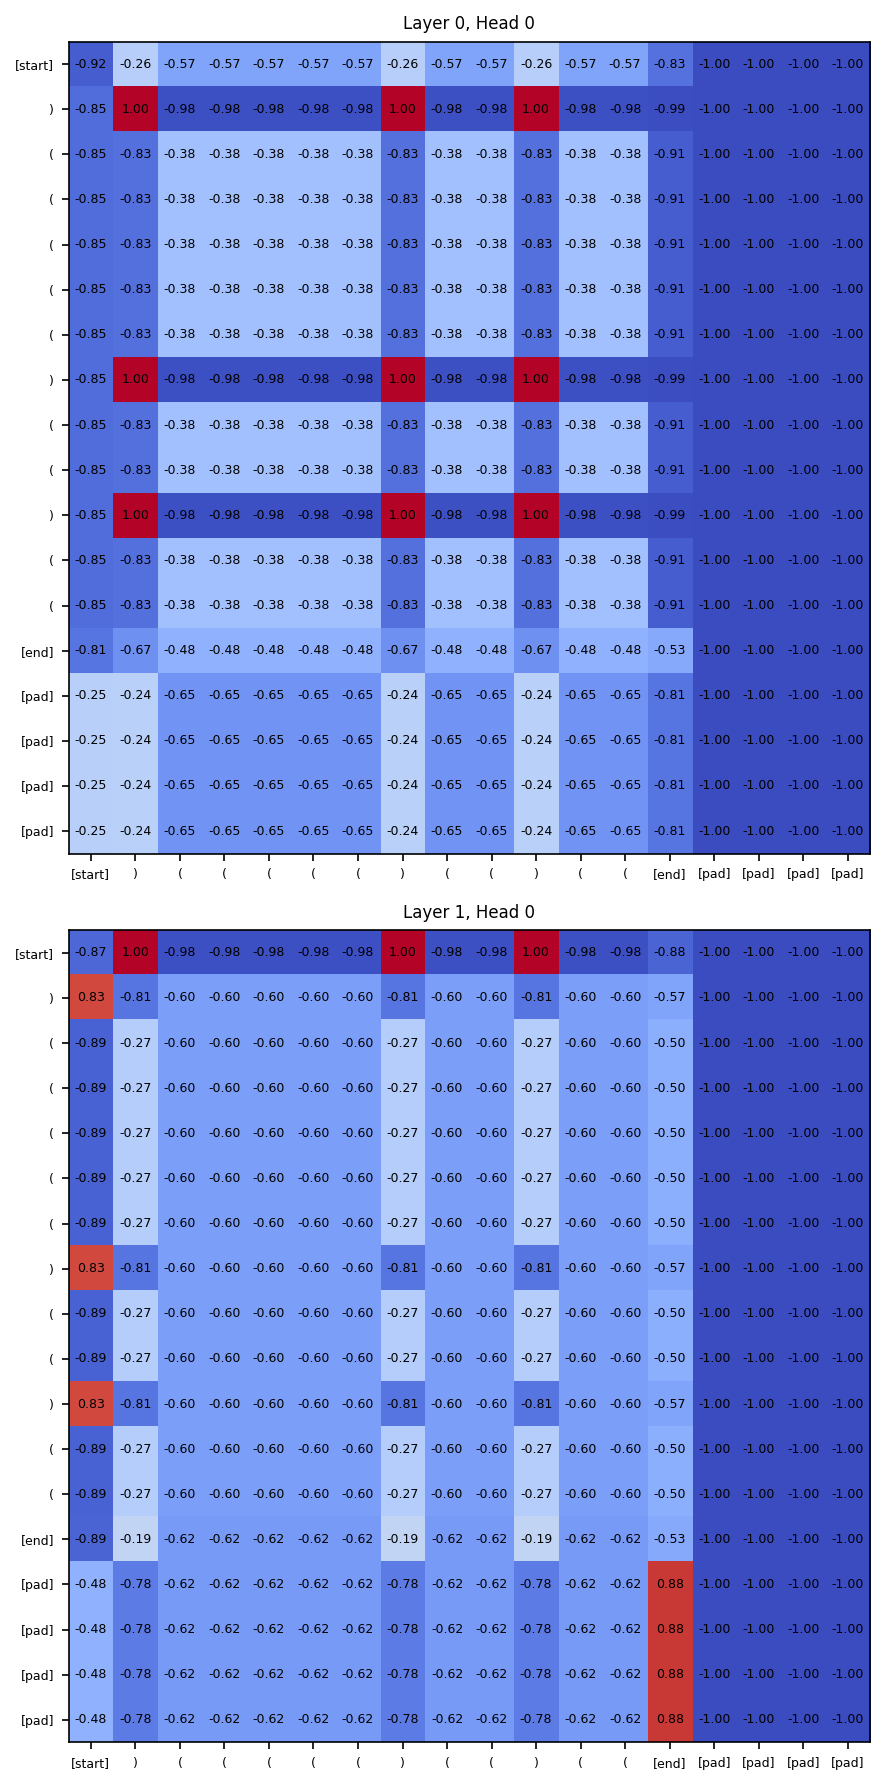

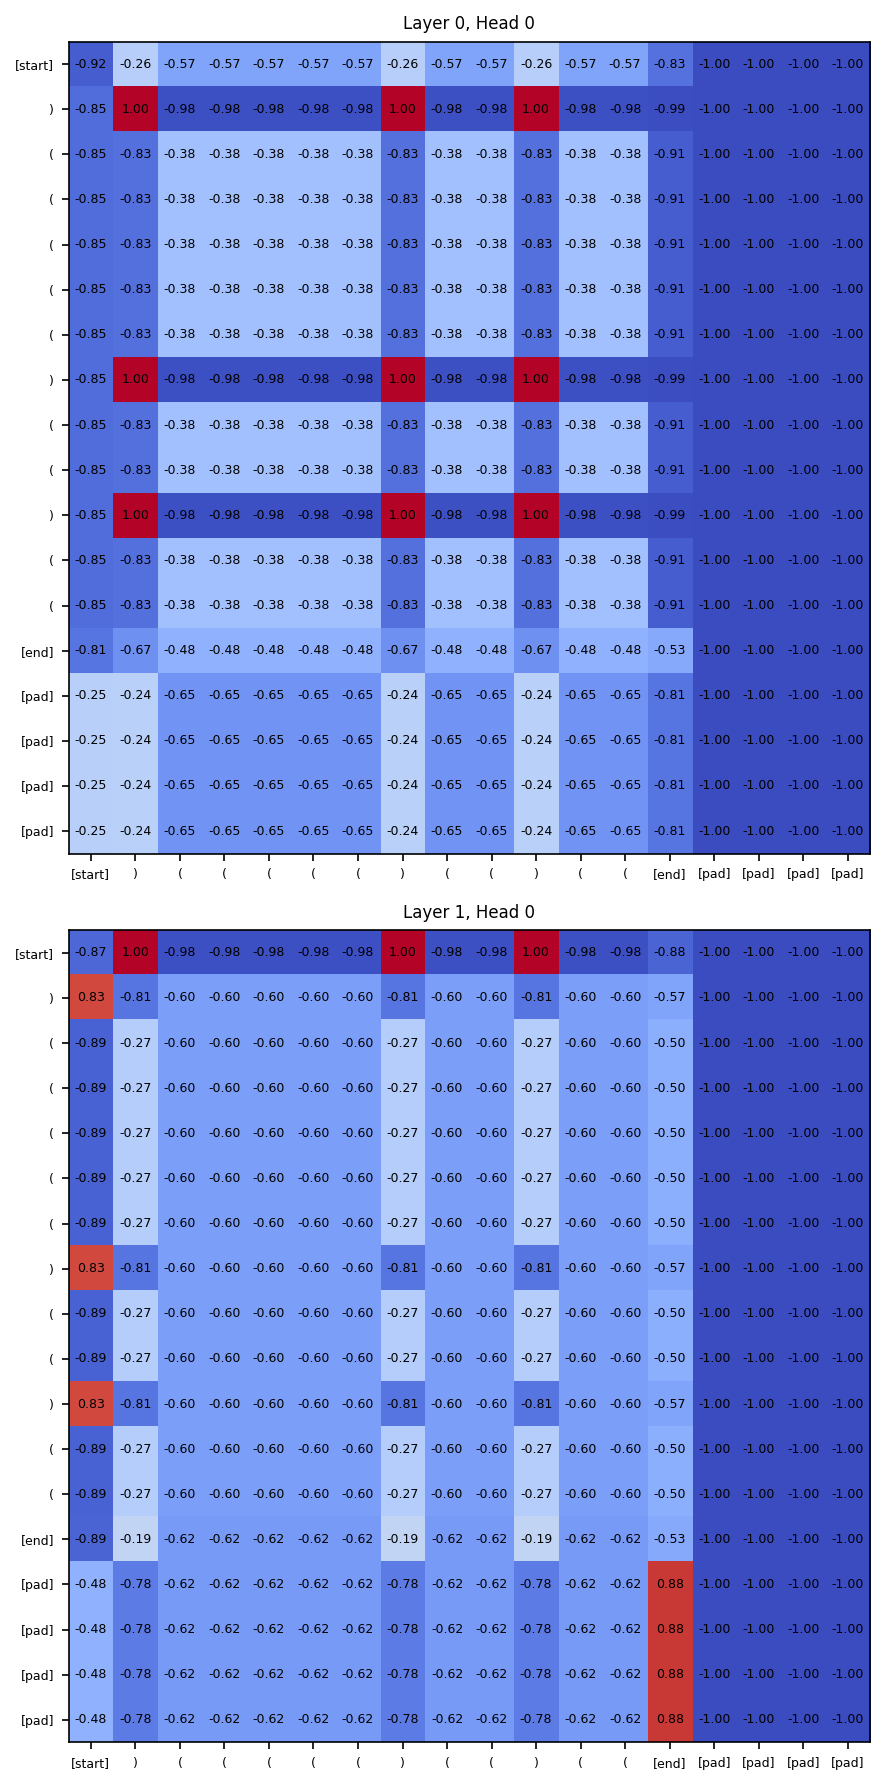

In [31]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

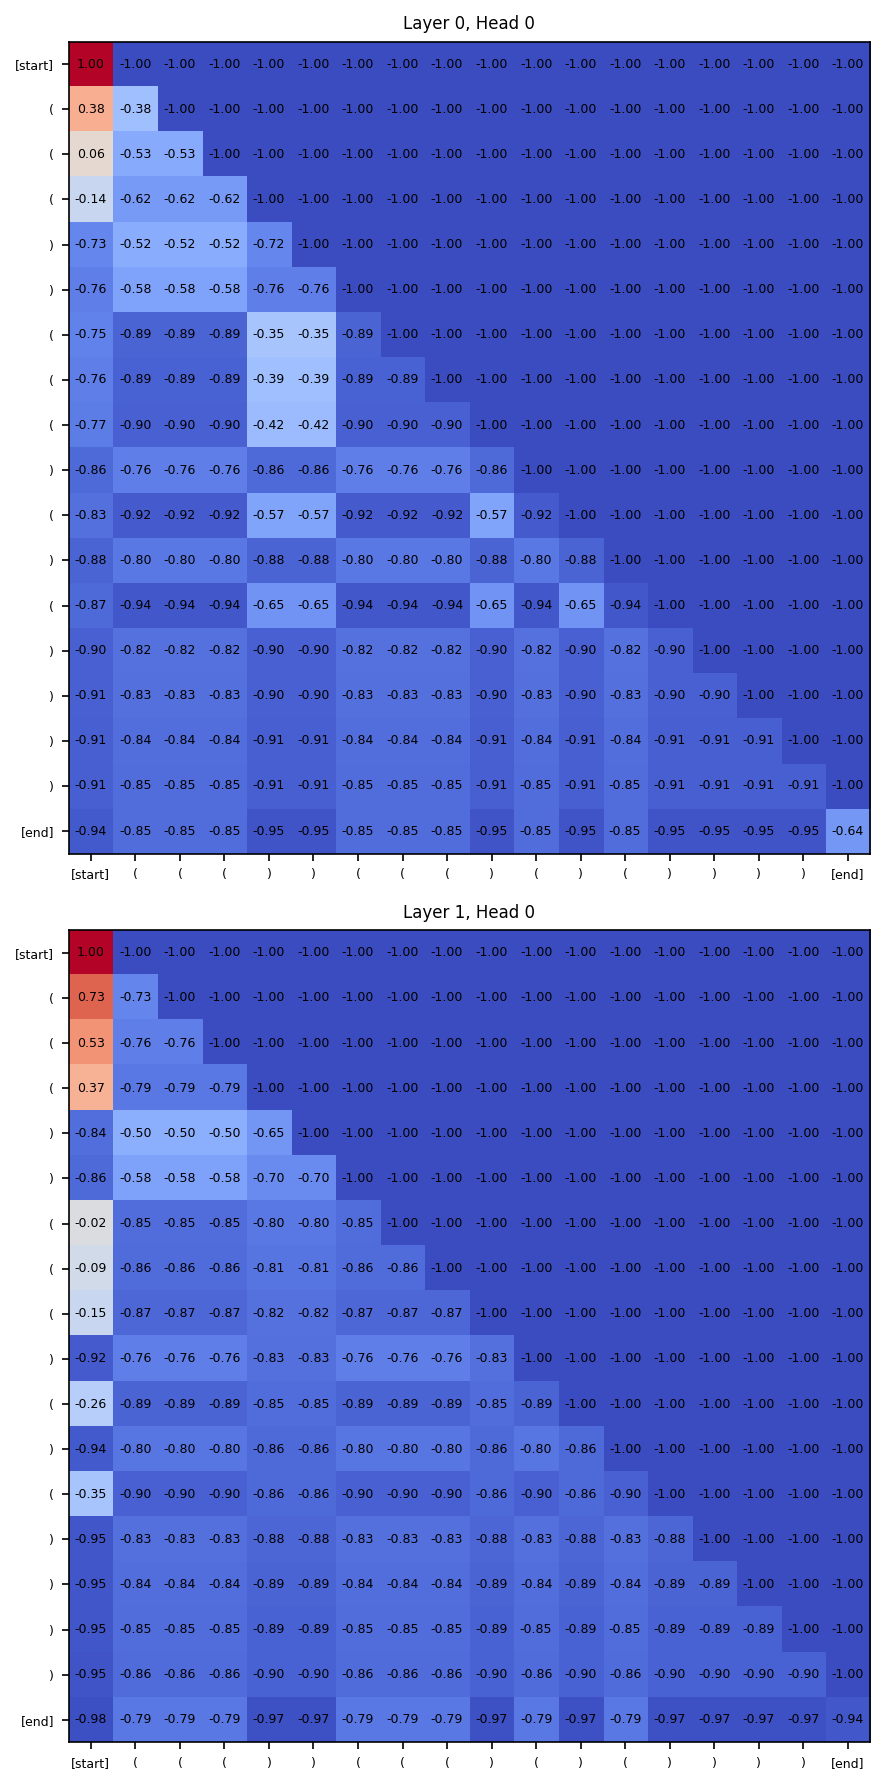

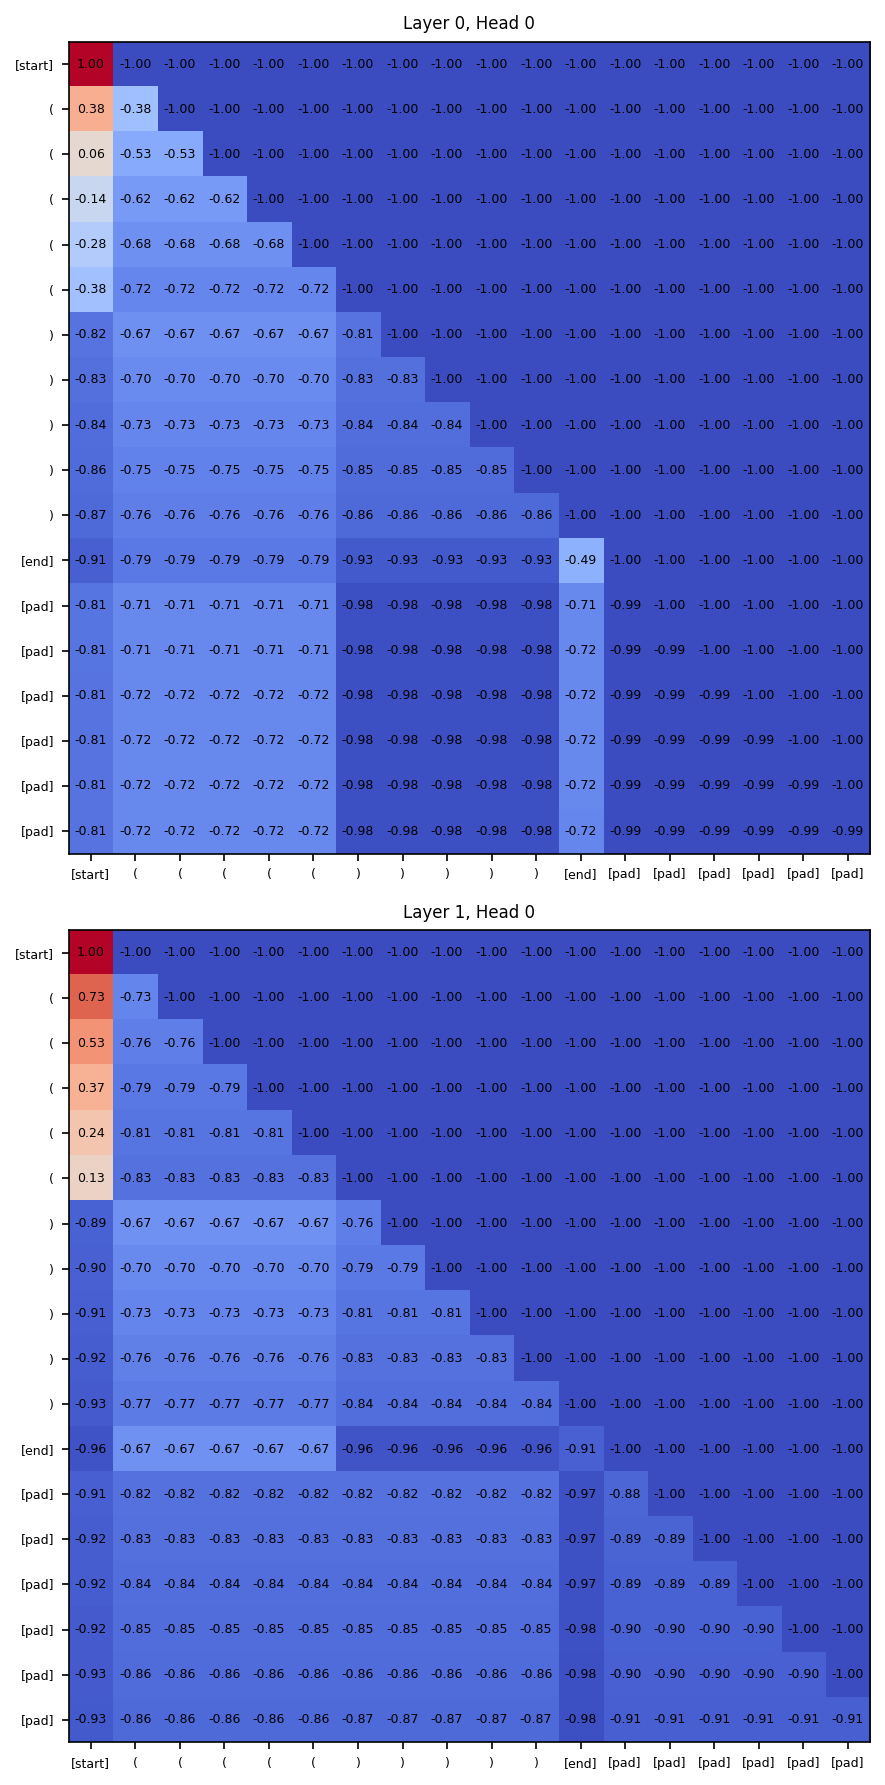

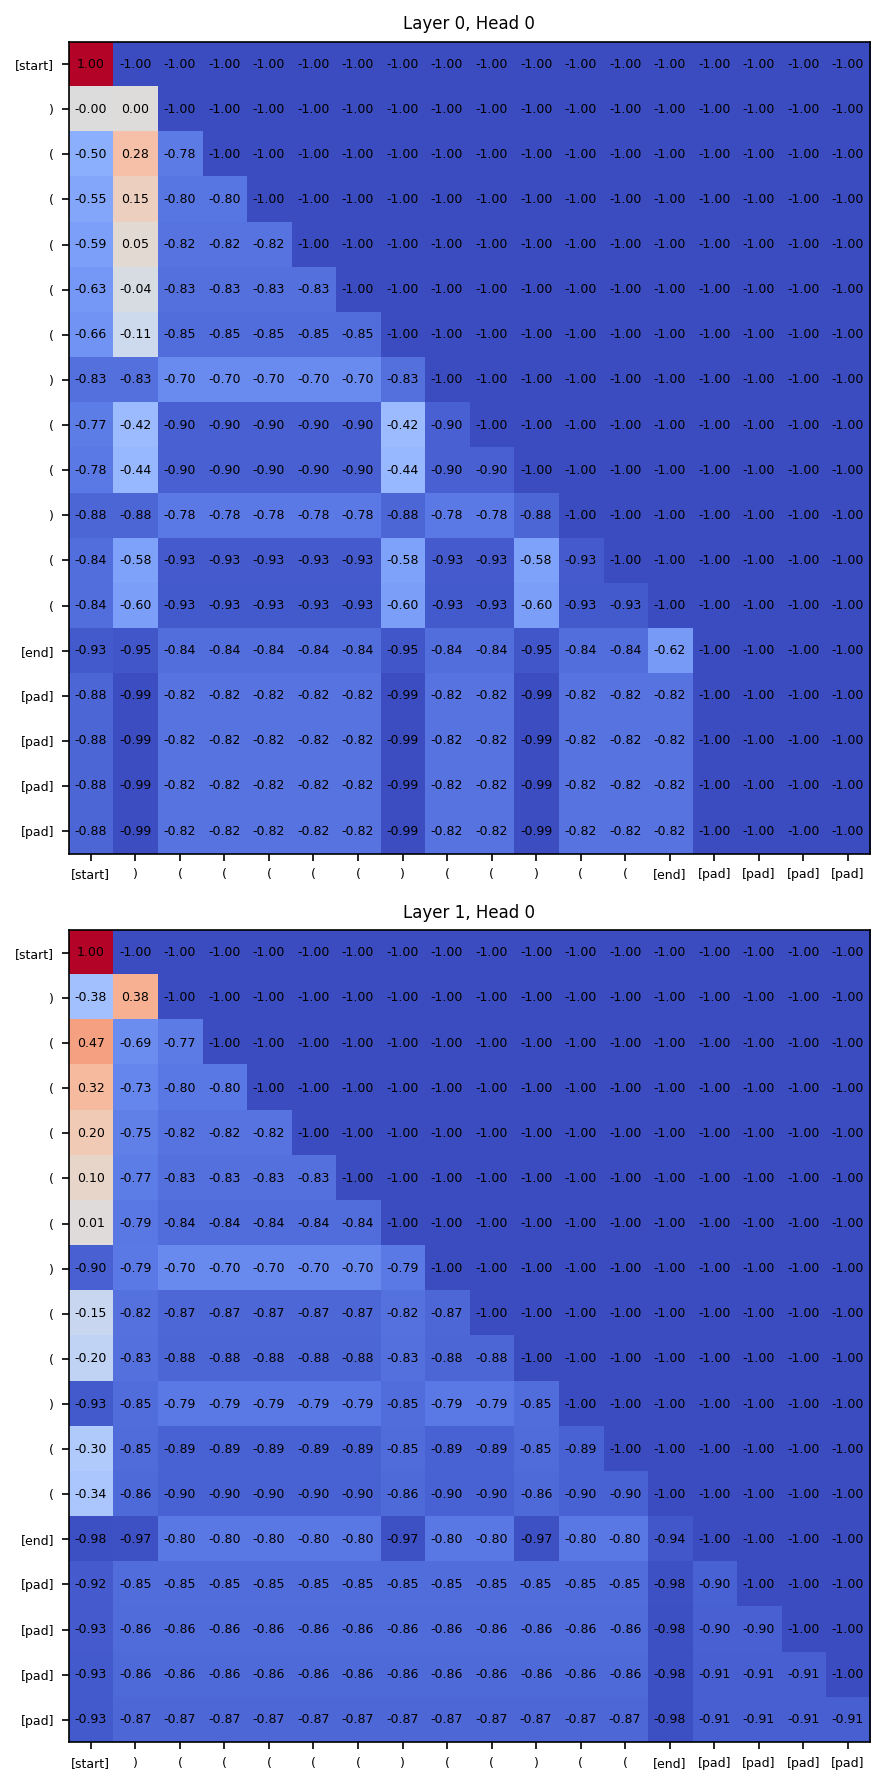

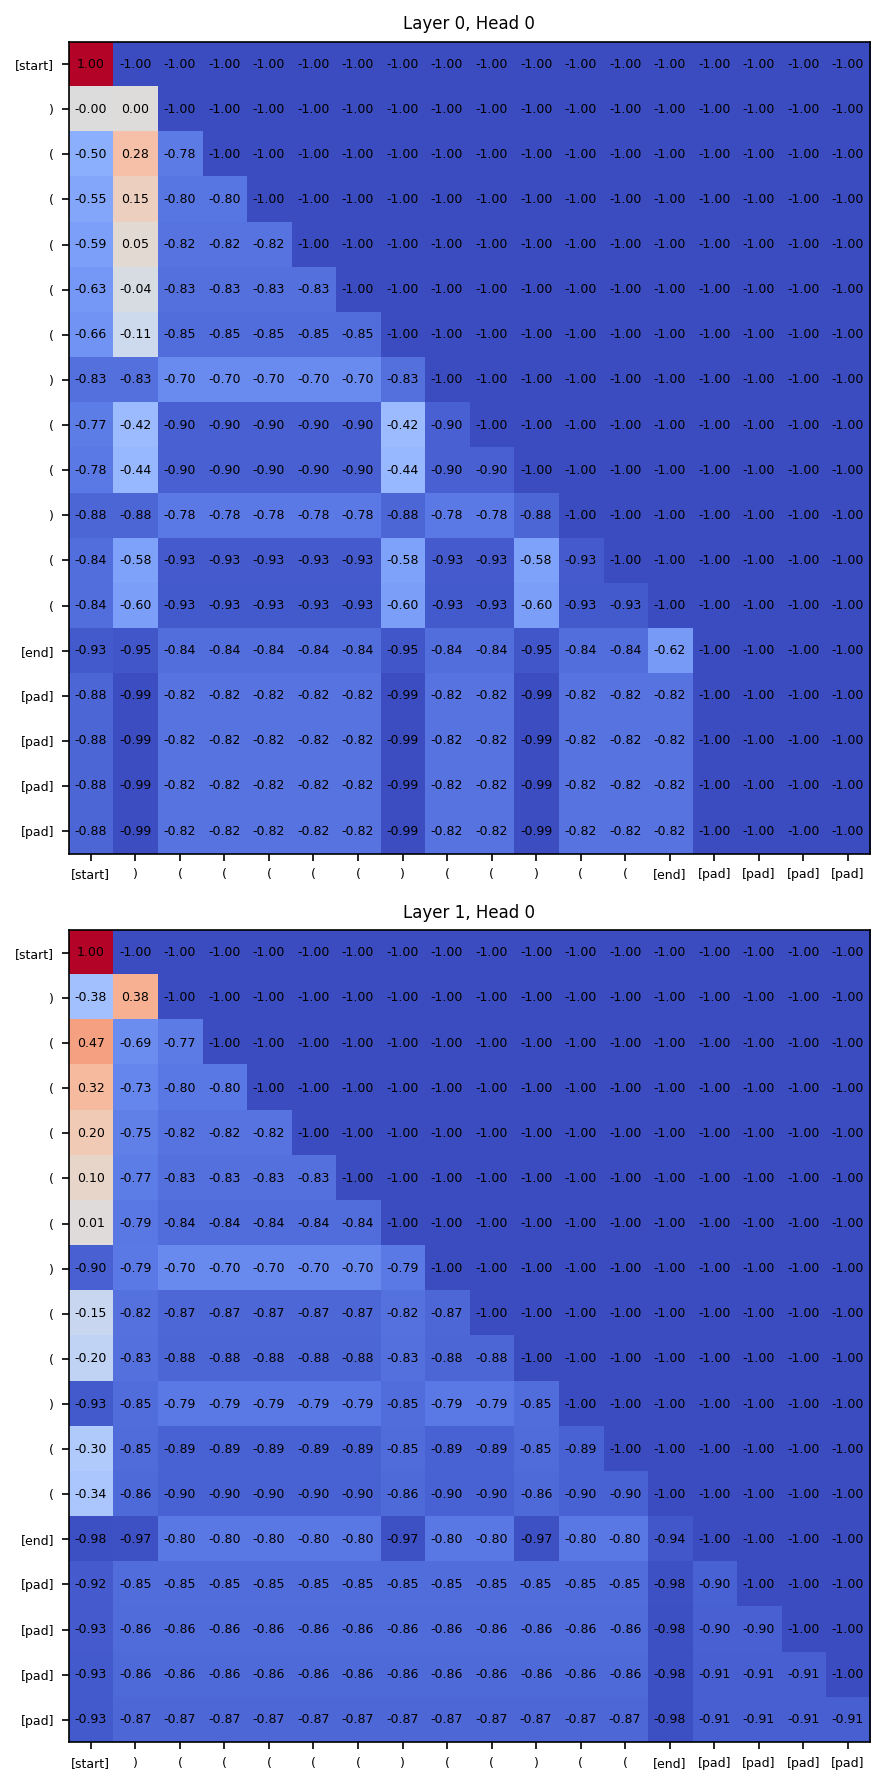

In [32]:
plot_attn_matrices(VOCAB, batch, model_causal, min_max_normalize, causal_mask)

# Experiment 2

Dyck-3


In [47]:
k = 3

In [48]:
path = generate_dataset(
    n=15_000,
    k=3,
    min_length=0,
    max_length=16,
    balanced=0.5,
)

File data/dyck-3_15000-samples_16-len_p05.jsonl already exists.


In [49]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()[]{}'

In [50]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-3_15000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 15000/15000 [00:00<00:00, 586599.54it/s]


In [51]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_dyck_2, [train_size, val_size, test_size])

In [52]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [53]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [54]:
model = TransformerClassifier(model_config).to(device)

In [55]:
model

TransformerClassifier(
  (embedding): Embedding(9, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [56]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [57]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.1586 | Train Accuracy: 83.14%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 49.5917 | Train Acc: 90.38%
Val Loss: 0.5035 | Val Acc: 100.00%
Epoch 2/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0122 | Train Accuracy: 99.98%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 2.8444 | Train Acc: 99.99%
Val Loss: 0.0624 | Val Acc: 100.00%
Epoch 3/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0040 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.8124 | Train Acc: 100.00%
Val Loss: 0.0246 | Val Acc: 100.00%
Epoch 4/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0023 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.4122 | Train Acc: 100.00%
Val Loss: 0.0127 | Val Acc: 100.00%
Epoch 5/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0012 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2417 | Train Acc: 100.00%
Val Loss: 0.0078 | Val Acc: 100.00%
Epoch 6/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1537 | Train Acc: 100.00%
Val Loss: 0.0050 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1038 | Train Acc: 100.00%
Val Loss: 0.0034 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0740 | Train Acc: 100.00%
Val Loss: 0.0024 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0549 | Train Acc: 100.00%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0412 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0324 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0257 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0212 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0179 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0155 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%


In [58]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/150 [00:00<?, ?it/s]

Test Loss: 0.0018 | Test Accuracy: 100.00%
Test Loss: 0.0028 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▃▂▅▁▂▄▂▂▂▄▆▁▄▃▂▅▂▂▆▃▃▄▃▂▃█▄▃▃▂▂▂▂▃▁▂▆▂▄▅
train/acc,▁▄▆█████████████████████████████████████
train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,▅█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,2e-05
train/acc,100.0
train/loss,8e-05
val/acc,100.0


In [59]:
batch = next(iter(test_dataloader))
batch

[(')', ')', ')[{[}[(}', '({})([])()', '[]{}[]', '{[{}]}', ')', ')[{[}[(}'),
 tensor([0., 0., 0., 1., 1., 1., 0., 0.], device='mps:0'),
 tensor([[0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 3., 7., 8., 4., 3., 5., 6., 4., 3., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 5., 6., 7., 8., 5., 6., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 7., 5., 7., 8., 6., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.]],
        device='mps:0')]

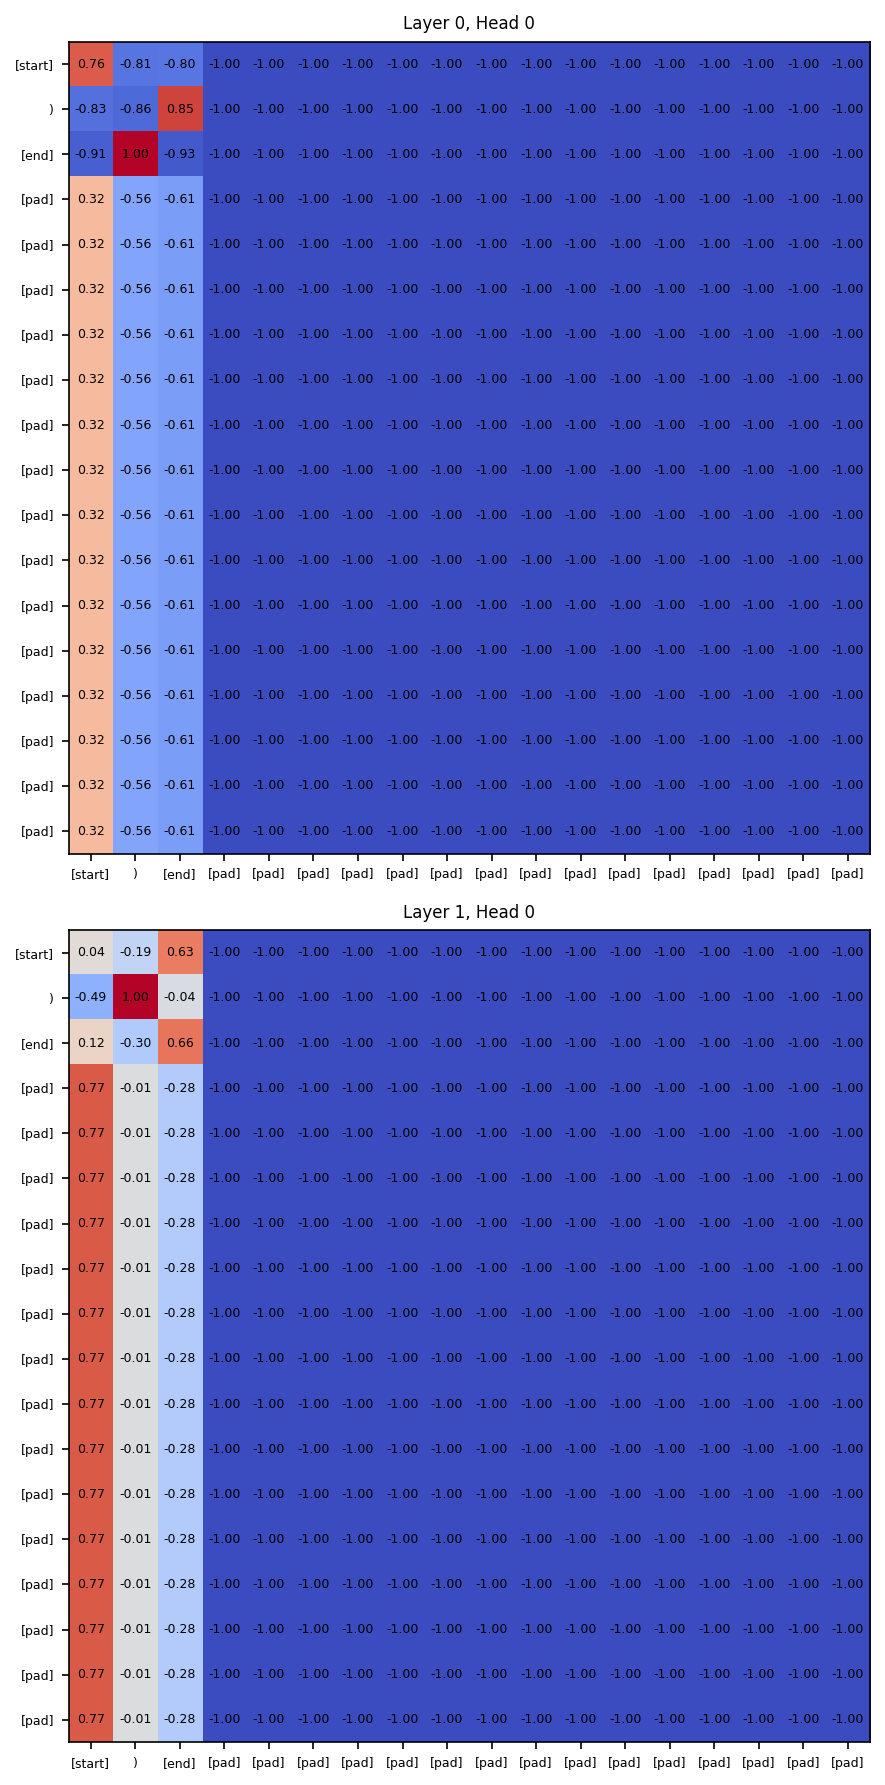

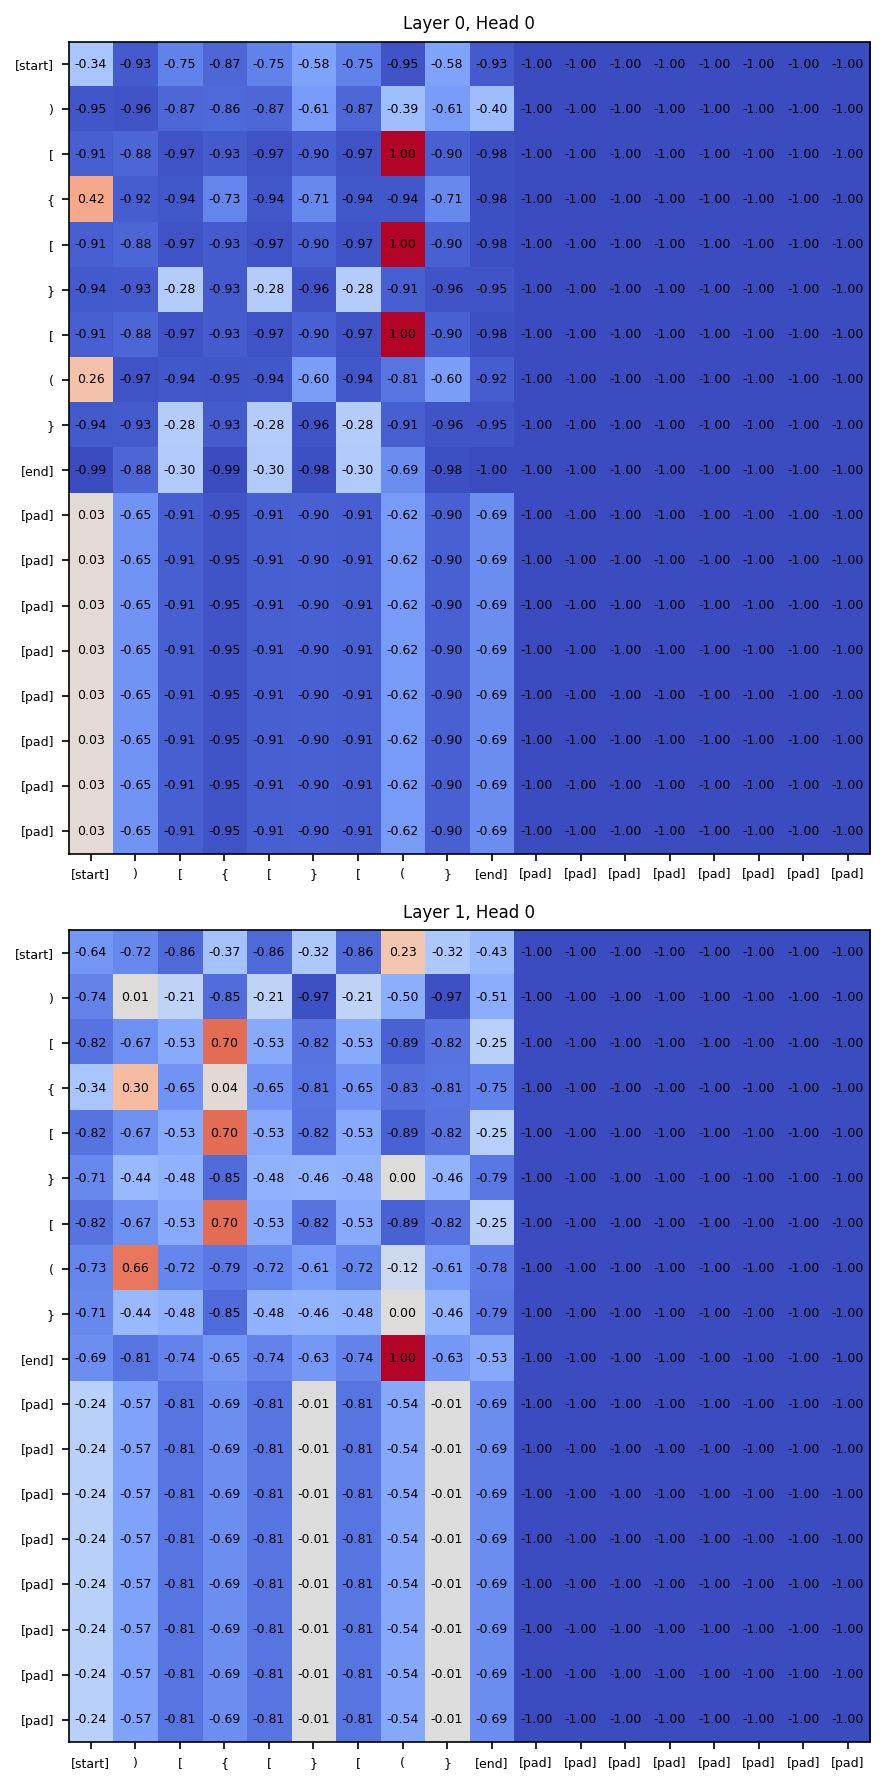

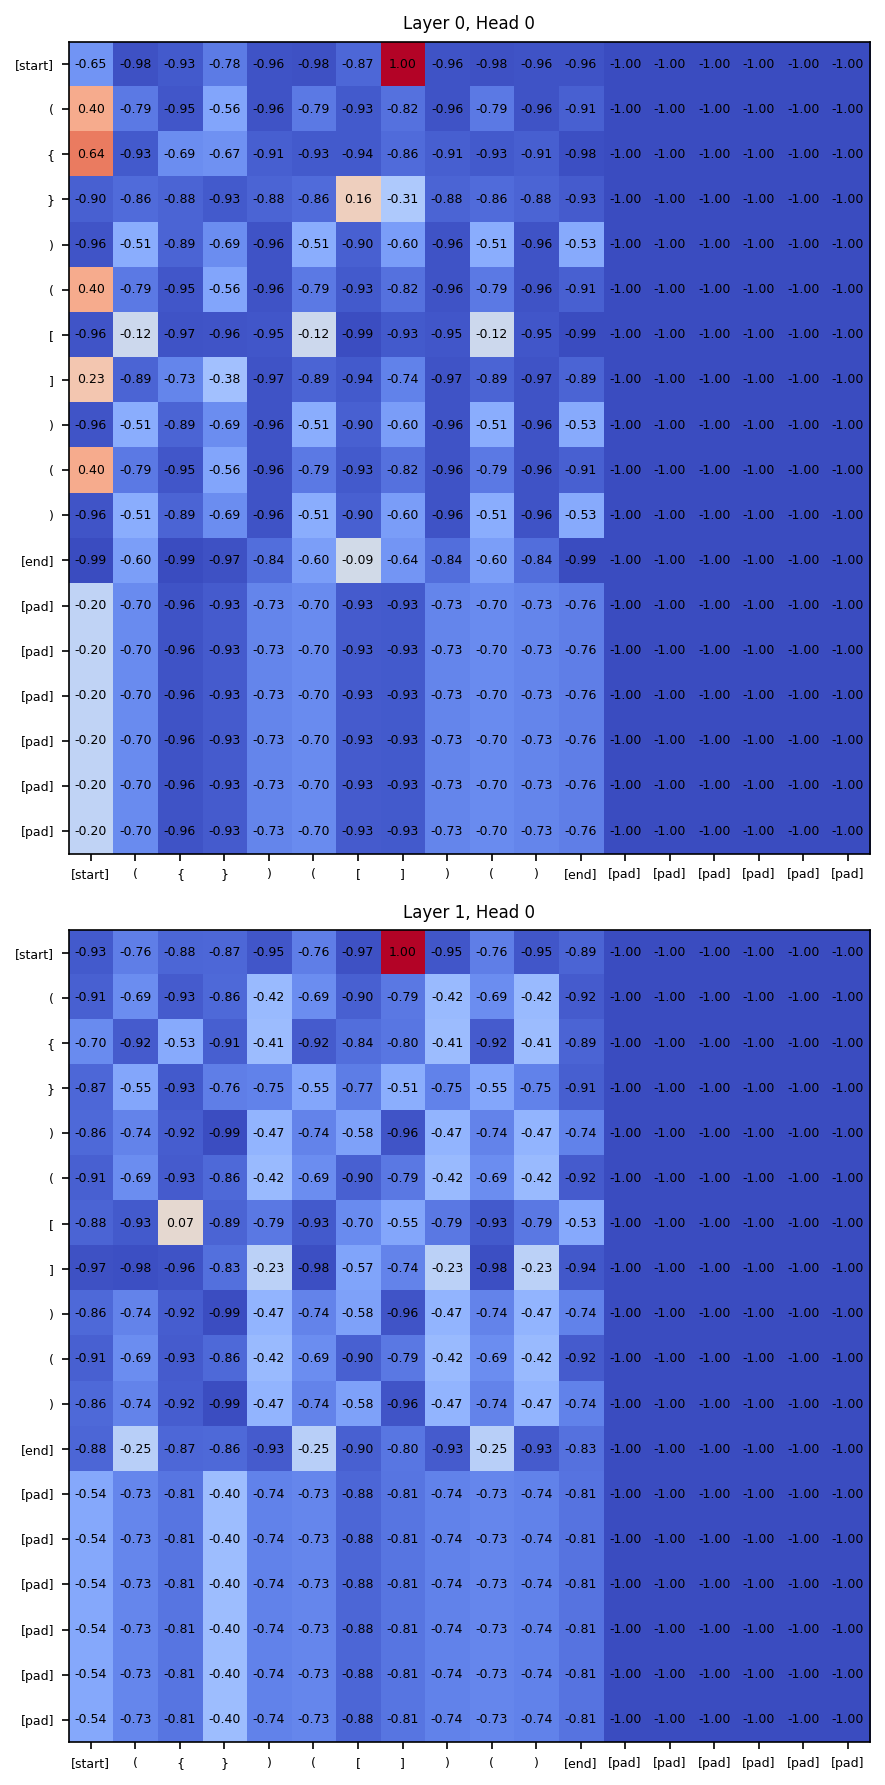

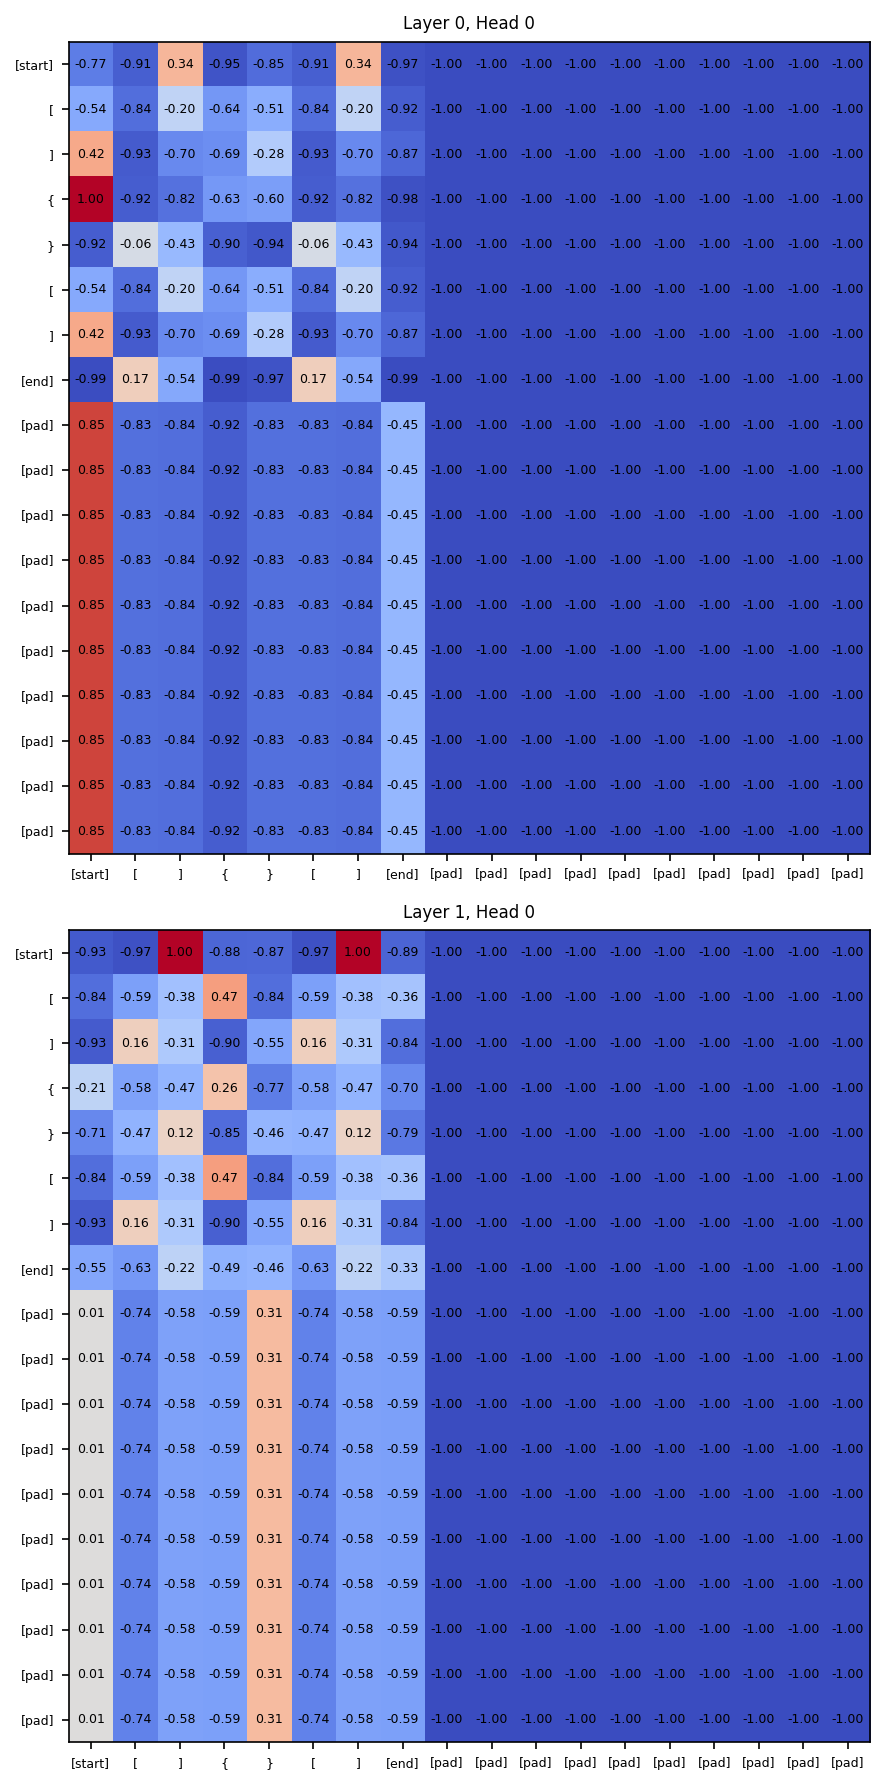

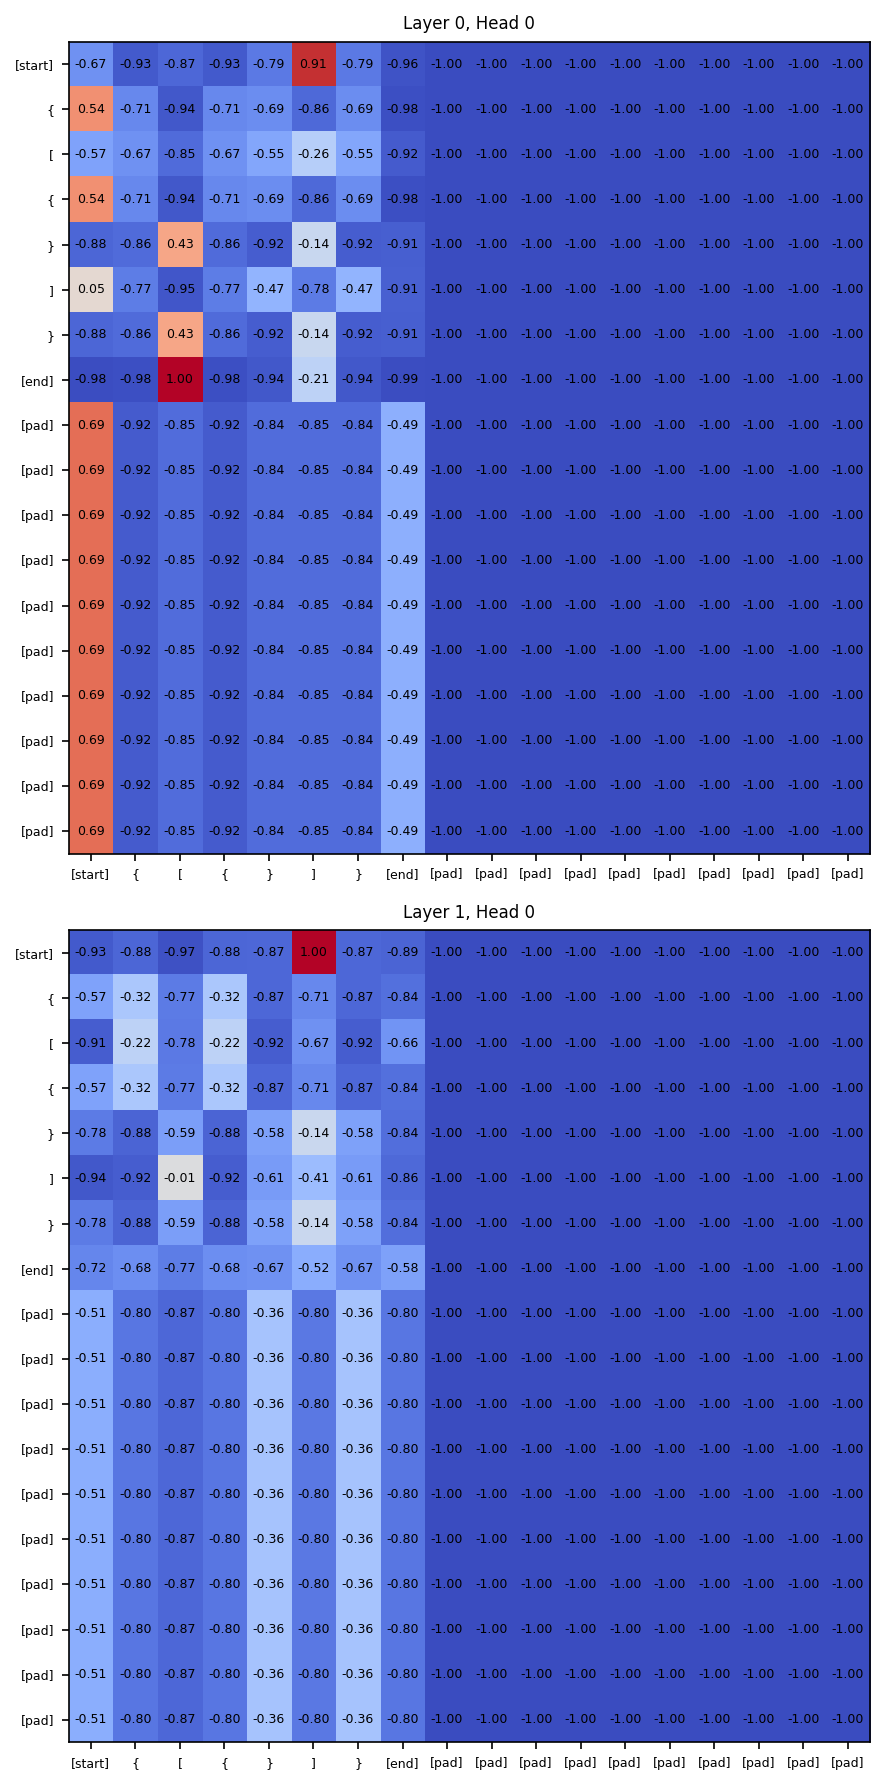

In [64]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)